In [63]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats,signal
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

# from mpl_toolkits.axes_grid1 import make_axes_locatable

import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, StackedHisto, SimpleHisto, mcplot, DrawMatrix

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [64]:
datafolder = '/media/disk1/kmason/detvars_highstats'
auxfolder = '../../data'
dumpfolder = '.'
tag = '2021-02-10'
plotfolder = 'outputs/PlotDumps'+tag
covfolder = 'outputs/covMatrix'+tag
covtag = 'frac_covar_run3_%s'%tag


RSE  = ['run','subrun','event']

## Run 3

In [65]:
# load in all the pickles I need
run = 'run3'
f_scaleslist = []
s_detsyslist = []
names = ['wiremodX','wiremodYZ','recomb','LYdown','LYAtt','LYRayleigh','SCE','wiremodThetaYZ','wiremodThetaXZ']

for name in names:
    s_detsyslist.append(name)

a_df_sys = []

RSE = ['run','subrun','event']
i=0
for sys in s_detsyslist:
    df_sys = pd.read_parquet('%s/pickles/%s_%s_%s.parquet'%(datafolder,sys,run,tag))
    i+=1
    a_df_sys.append(df_sys)
    print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))


total 327918, cv = 315002 dv = 12916
total 327860, cv = 315002 dv = 12858
total 12348, cv = 5823 dv = 6525
total 325739, cv = 315002 dv = 10737
total 325976, cv = 315002 dv = 10974
total 327469, cv = 315002 dv = 12467
total 11684, cv = 5823 dv = 5861
total 327883, cv = 315002 dv = 12881
total 326568, cv = 315002 dv = 11566


In [66]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
# customized for the pi0 variables: pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,Mpid_muon
#varlistSel = {}

varlistSel = {}

varlistSel['_pi0mass_new']=distVar('_pi0mass_new',(30,350),'Reco Pi0 Mass (MeV)',covfolder+'/'+covtag+'__pi0mass.txt')
varlistSel['DeltaMass_new']=distVar('DeltaMass_new',(1000,1400),'Reco Delta Mass (MeV)',covfolder+'/'+covtag+'__deltamass.txt')
varlistSel['shower1_E_Y_new']=distVar('shower1_E_Y_new',(80,450),'Reco Shower1 Energy (MeV)',covfolder+'/'+covtag+'__shower1E.txt')
varlistSel['shower2_E_Y_new']=distVar('shower2_E_Y_new',(35,450),'Reco Shower2 Energy (MeV)',covfolder+'/'+covtag+'__shower2E.txt')
varlistSel['pi0_energy_reco_new']=distVar('pi0_energy_reco_new',(100,750),'Reco Pi0 Energy (MeV)',covfolder+'/'+covtag+'__pi0energy.txt')
varlistSel['pi0_momentum_reco_new']=distVar('pi0_momentum_reco_new',(100,700),'Reco Pi0 Momentum (MeV)',covfolder+'/'+covtag+'__pi0momentum.txt')
varlistSel['MPID_muon']=distVar('MPID_muon',(0,1),'MPID Muon Score',covfolder+'/'+covtag+'__mpidmuon.txt')


In [67]:
a_overlap_sys = []
a_cv_sys = []
for df in a_df_sys:
    a_cv_sys.append(df.sort_values('shower1_E_Y',ascending=True).drop_duplicates(RSE).sort_index())
    a_overlap_sys.append(df.sort_values('shower1_E_Y',ascending=True).drop_duplicates(RSE).sort_index())

## build covariance matrices!


In [68]:
# define cuts
cuts = 'good ==1 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7'

s_cuts = cuts + ' and ' +  'isCV ==False'
s_cuts_cv = cuts + ' and ' +  'isCV ==True'

In [69]:
#Bring in the required modules
from scipy import *
from scipy import signal
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import lfilter
import scipy.signal
from scipy.optimize import leastsq
import pandas as pd
import scipy.stats as stats
import matplotlib.mlab as mlab
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from random import random




def smooth(cv_list,dv_list,xmin,xmax,dv_name,cv_weights=1,dv_weights=1,ratio=1,nbin=20):
    
#----------------------------------------------------------------
# This section is the CV
    ext_bin=10
    cv = np.array(cv_list)
    dv = np.array(dv_list)
    cv_w = np.array(cv_weights+0.00000001)
    dv_w = np.array(dv_weights+0.00000001)

    if (cv_w.size==1 or dv_w.size==1):
        cv_w = np.ones(cv.size)
        dv_w = np.ones(dv.size)
    elif (cv.size != cv_w.size or dv.size != dv_w.size):
        print('##############     ERROR weights and lists are not matching sizes ####################')
        return(0,0)

# throw away the data points outside of the hist limits to fake the real data
#    mask1 = np.logical_and(cv >= xmin, cv <= xmax)
#    cv = cv[mask1]
        
    cv_hist, binedges = np.histogram(cv, bins = nbin, range = (xmin, xmax),weights=cv_w)
    cv_hist= cv_hist+0.000001 # assure no zero bins    


#-------------------------------------------------------------------------------
# look for spikes at edges and remove them.  Smoothing cannot handle these.
    
    # flags for bin drops
    drop0=False
    dropn=False
    
    # throw away the first bin if needed
    # do this if the change is more than 80%
    print('cv[0] =  %f    cv[1] = %f  rat = %f'%(cv[0],cv[1],cv[0]/(cv[0]+cv[1])))

#    if ((cv_hist[0]/(cv_hist[0]+cv_hist[1]))>0.80):
#        drop0=True

#    if ((cv_hist[nbin-1]/(cv_hist[nbin-2]+cv_hist[nbin-1]))>0.80):
#        dropn=True


    # throw away the firstand/or last bin if needed
        
    if (drop0):    
        mask1 = np.logical_and(cv >= binedges[1], cv <= xmax)
        cv = cv[mask1]
        cv_w = cv_w[mask1]
        print('----------------------------drop0_cv')
        
    if (dropn):
        mask1 = np.logical_and(cv >= xmin, cv <=  binedges[nbin-1])
        cv = cv[mask1]
        cv_w = cv_w[mask1]

        print('dropn_cv')
        
    #-------------------------------------------------------------------------------
# CV smoothing, calculate the bandwidth for use throughout
        
        
# calculate Sheather/Jones bandwidth
    bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
    print('bwid = %f'%bwid)
    
    # This smoothing library wants 2d so pad it out
    cv2d=cv [:, np.newaxis]

    
    myrange = (lambda edges: (edges[:-1] + edges[1:])/2.0)(np.linspace(xmin,xmax,(ext_bin*nbin)+1))
    range2d=myrange [:, np.newaxis]
#    print(myrange)

#----------------------------------------------------------------
# This section is the detvar

#
# Create Fake data np.histograms,aiming for about 4000 events in the np.histogram
#
    # This smoothing library wants 2d so pad it out
    dv2d=dv [:, np.newaxis]
    dv_hist, binedges = np.histogram(dv, bins = nbin, range = (xmin, xmax),weights=dv_w)
    dv_hist= ratio*dv_hist+0.000001 # assure no zero bins    

    # throw away the firstand/or last bin if needed
        
    if (drop0):    
        mask1 = np.logical_and(dv >= binedges[1], dv <= xmax)
        dv = dv[mask1]
        print('-----------------------------------drop0_dv')
        dv_w = dv_w[mask1]

        
    if (dropn):
        mask1 = np.logical_and(dv >= xmin, dv <=  binedges[nbin-1])
        dv = dv[mask1]
        print('drop0_dv')
        dv_w = dv_w[mask1]
        
        #----------------------------------------------------------------
# Smooth both CV AND DV, Fix up the edge bins.
         
    #get the CV smoothed case and normalize it

    gkdeCV= KernelDensity(kernel='epanechnikov', bandwidth=bwid).fit(cv2d,sample_weight=cv_w)
    mykdeCV = np.exp(gkdeCV.score_samples(range2d))
    yhatCV=np.zeros(ext_bin*nbin)
#    yhatCV=(mykdeCV)*(cv.shape[0])/sum(mykdeCV)
    yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)

    #get the DV smoothed case and normalize it
    gkdeDV= KernelDensity(kernel='epanechnikov', bandwidth=bwid).fit(dv2d,sample_weight=dv_w)
    mykdeDV = np.exp(gkdeDV.score_samples(range2d))

    yhatDV=np.zeros(ext_bin*nbin)
#    yhatDV=(mykdeDV)*dv.shape[0]/sum(mykdeDV)
    yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)

       
    # rebin the ratio into the bins we will use by summing the bin...
    smoothrat=np.zeros(nbin)
    smoothCV=np.zeros(nbin)
    smoothDV=np.zeros(nbin)

    k=0
    
    for j in range(nbin):
        ratvalCV=0.
        ratvalDV=0.
        for n in range(ext_bin):
            ratvalCV+=yhatCV[k]
            ratvalDV+=yhatDV[k]
            k+=1
        if ratvalCV==0:
            smoothrat[j]=1
        else:
            smoothrat[j]=ratvalDV/ratvalCV
        smoothCV[j]=ratvalCV
        smoothDV[j]=ratvalDV
    
    # put the first and/or last bin back if needed
    if (drop0):
        smoothrat[0]=dv_hist[0]/cv_hist[0]
    if (dropn):
        smoothrat[nbin-1]=dv_hist[nbin-1]/cv_hist[nbin-1]

    
    offset = (xmax - xmin )/(2*nbin)
    x= np.linspace(xmin+offset,xmax-offset,nbin)
    
    plt.plot(x, cv_hist, linewidth=1, linestyle="-", c="b",label='cv')  # smooth by filter
    plt.plot(x, dv_hist, linewidth=1, linestyle="-", c="g",label='dv')  # smooth by filter

    plt.plot(x, smoothCV, linewidth=1, linestyle="--", c="b",label='cv_smooth')  # smooth by filter

    plt.plot(x, smoothDV, linewidth=1, linestyle="--", c="g",label='dv_smooth')  # smooth by filter
    plt.legend()
    plt.title(dv_name)
    plt.savefig(plotfolder+'/detsys_%s_%s_%s_full_hists.png'%(dist.myname, run,dv_name),dpi=120,bbox_inches='tight')
    
    plt.show()
    if(dv_hist[0]==0.000001):
        dv_hist[0]=0
    plt.plot(x, dv_hist/cv_hist, linewidth=1, linestyle="-", c="b",label='original')  # smooth by filter
    plt.plot(x,smoothrat , linewidth=1, linestyle="-", c="m",label='smoothed')  # smooth by filter
    plt.legend()
    plt.title(dv_name)

    plt.savefig(plotfolder+'/detsys_%s_%s_%s_ratio.png'%(dist.myname, run,dv_name),dpi=120,bbox_inches='tight')

    plt.show()


    return(smoothCV,smoothDV)

9
0
cv = 2807  and dv = 4263
cv POT = 898773223801000034304.000000 dv POT = 1309153192370000101376.000000
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


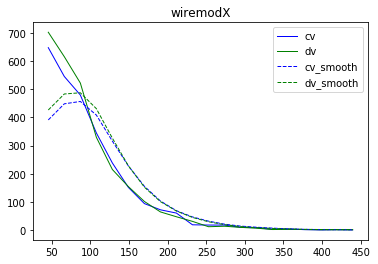

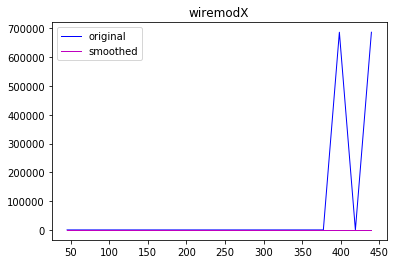

shower2_E_Y_new [8.19346519e-03 6.08598162e-03 4.55819090e-03 3.09498702e-03
 1.09783468e-03 7.23186352e-06 3.98451318e-04 4.30456932e-04
 2.74941813e-04 1.45080725e-03 5.02146216e-03 7.55825301e-03
 1.48423730e-02 3.53450338e-02 3.02316028e-02 1.05388404e-02
 3.89782820e-08 6.52210941e-02 1.94451921e-01 1.74329261e-01]
shower2_E_Y_new [7.14152850e-03 1.66374532e-02 7.86264550e-03 2.01595655e-03
 9.54122797e-03 3.63362038e-04 6.41792722e-03 1.10669281e-02
 4.77886468e-02 4.45194625e-01 1.14723594e-01 5.79260849e-02
 2.02093391e-04 5.18261193e-02 9.82633055e-02 9.82633055e-02
 1.39174086e-01 0.00000000e+00 9.82633055e-02 0.00000000e+00]


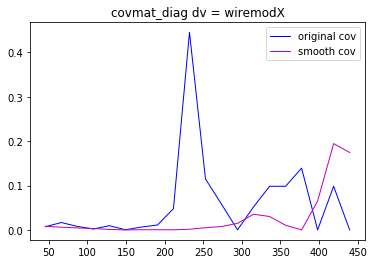

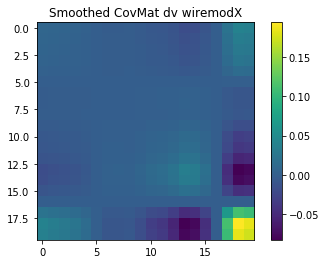

1
cv = 2807  and dv = 4132
cv POT = 898773223801000034304.000000 dv POT = 1310970606080000000000.000000
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


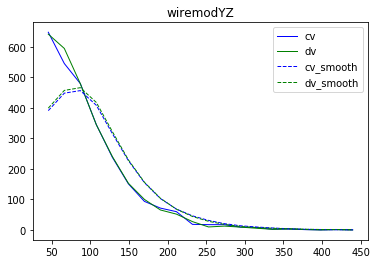

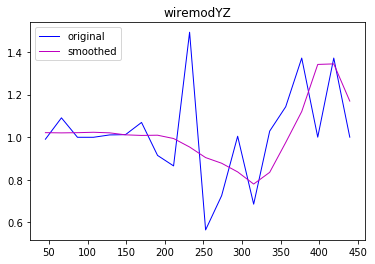

shower2_E_Y_new [4.45908293e-04 4.03042878e-04 4.42412294e-04 5.25821160e-04
 4.11518984e-04 1.17977112e-04 6.56021114e-05 8.39835972e-05
 4.07224204e-05 2.13900565e-03 9.19420362e-03 1.49861439e-02
 2.65952194e-02 4.84487511e-02 2.72559156e-02 6.28132667e-04
 1.44776132e-02 1.16494766e-01 1.18226733e-01 2.86604056e-02]
shower2_E_Y_new [9.18547122e-05 8.21032993e-03 3.48489035e-07 3.38633890e-07
 1.07963884e-04 1.39745616e-04 4.76764336e-03 7.34810543e-03
 1.81981388e-02 2.42415600e-01 1.89506599e-01 7.54242640e-02
 1.79903636e-05 9.88608978e-02 8.04726782e-04 2.03435409e-02
 1.37757476e-01 0.00000000e+00 1.37757476e-01 0.00000000e+00]


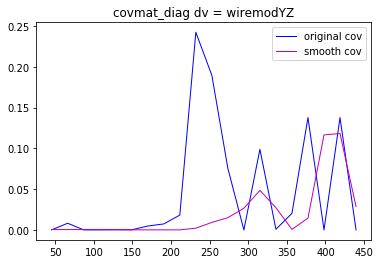

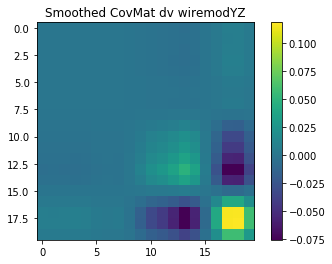

2
cv = 1871  and dv = 2079
cv POT = 579534847420999991296.000000 dv POT = 637062455184000024576.000000
cv[0] =  104.511012    cv[1] = 107.527385  rat = 0.492887
bwid = 89.562916


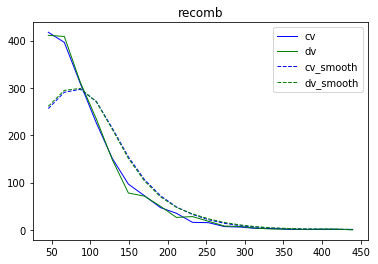

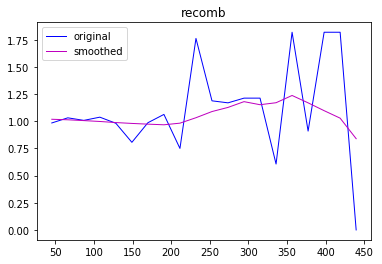

shower2_E_Y_new [3.39487941e-04 1.86923407e-04 3.79107128e-05 3.50836455e-06
 1.41499552e-04 3.94424744e-04 7.01735193e-04 1.04858332e-03
 3.03602295e-04 1.06777230e-03 8.01076459e-03 1.62814246e-02
 3.26044231e-02 2.32209373e-02 2.91255708e-02 5.63694267e-02
 2.87665345e-02 9.52566256e-03 8.16610934e-04 2.57118277e-02]
shower2_E_Y_new [2.41204258e-04 1.00397394e-03 6.75779077e-05 1.42560501e-03
 3.44238927e-04 3.75213927e-02 1.78481011e-04 3.97470113e-03
 6.25222879e-02 5.81468944e-01 3.54039060e-02 2.87684116e-02
 4.53398307e-02 4.53398307e-02 1.54869199e-01 6.71411894e-01
 8.15433609e-03 6.71411894e-01 6.71411894e-01 1.00000000e+00]


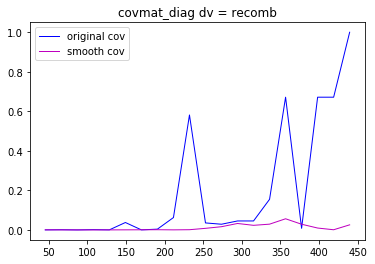

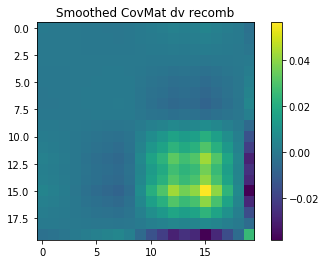

3
cv = 2807  and dv = 3619
cv POT = 898773223801000034304.000000 dv POT = 1218083168320000098304.000000
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


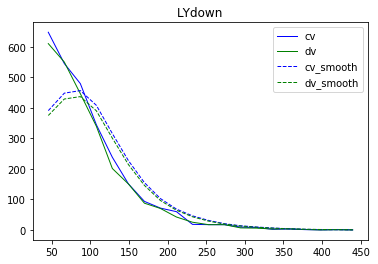

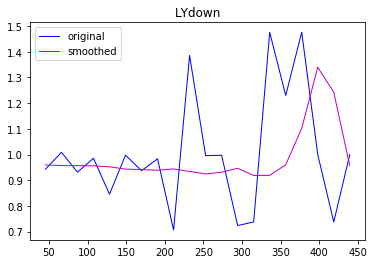

shower2_E_Y_new [0.00165195 0.00182835 0.00186859 0.00192773 0.00227699 0.00322063
 0.00341388 0.00373166 0.00314046 0.00432167 0.00565718 0.00477615
 0.00286985 0.00663809 0.00656238 0.00159108 0.01034412 0.11532824
 0.0586548  0.00188955]
shower2_E_Y_new [3.31487635e-03 7.70040218e-05 4.73134794e-03 2.11470170e-04
 2.38391962e-02 5.53217221e-06 3.94419161e-03 2.69623333e-04
 8.59765746e-02 1.48475758e-01 1.92494456e-05 7.39281907e-06
 7.63626973e-02 6.87180781e-02 2.26306983e-01 5.27917008e-02
 2.26306983e-01 0.00000000e+00 6.87180781e-02 0.00000000e+00]


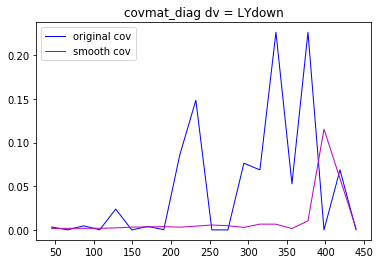

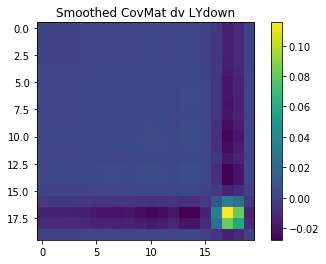

4
cv = 2807  and dv = 3622
cv POT = 898773223801000034304.000000 dv POT = 1212833087030000091136.000000
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


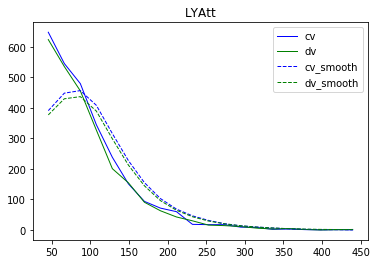

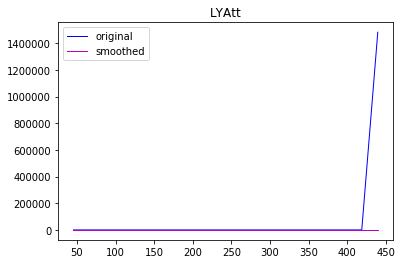

shower2_E_Y_new [1.27551194e-03 1.68602265e-03 1.88539037e-03 2.14284622e-03
 2.91056176e-03 4.15776865e-03 4.47842476e-03 4.27784251e-03
 3.15262981e-03 4.14119070e-03 4.39124115e-03 8.81032211e-04
 1.25481021e-05 8.40788381e-04 1.84752744e-07 8.39084063e-03
 7.30895341e-02 4.35647769e-01 5.60074133e-01 1.87649597e-01]
shower2_E_Y_new [1.37798104e-03 3.23588344e-04 2.48142775e-03 2.59519205e-03
 2.45364980e-02 5.03659398e-04 9.08740960e-04 1.48830356e-02
 8.41917355e-02 4.03478304e-01 7.64229442e-03 3.34464022e-02
 4.46579436e-02 6.70537084e-02 2.32425601e-01 2.32425601e-01
 2.32425601e-01 0.00000000e+00 6.70537084e-02 0.00000000e+00]


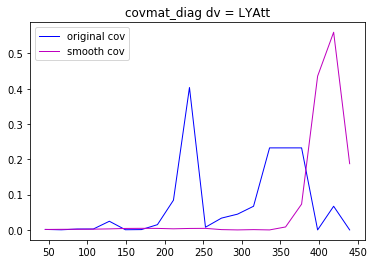

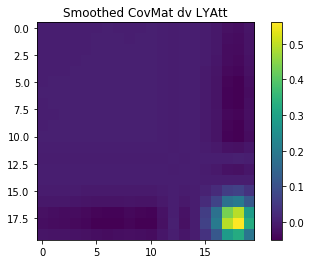

5
cv = 2807  and dv = 4055
cv POT = 898773223801000034304.000000 dv POT = 1308303170610000035840.000000
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


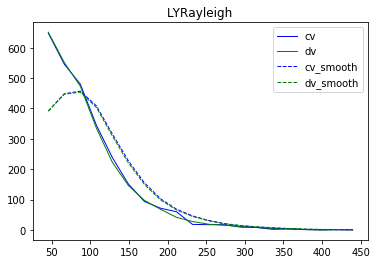

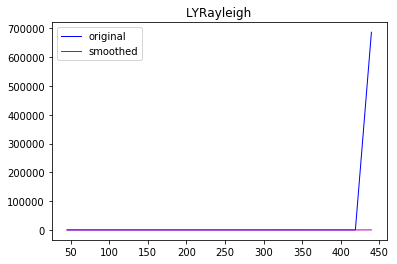

shower2_E_Y_new [3.97503415e-06 1.10292109e-05 5.81107001e-05 1.56055905e-04
 4.13077271e-04 8.63652391e-04 1.22848791e-03 1.32630470e-03
 1.26142799e-03 1.36699313e-03 1.32345007e-03 1.95026215e-05
 6.02383411e-03 9.94914264e-03 2.68660984e-02 9.40656245e-02
 2.24512275e-01 4.58878802e-01 2.72414144e-01 2.18043390e-02]
shower2_E_Y_new [1.68952146e-05 1.01629259e-04 1.91362657e-04 7.32753827e-04
 4.21994772e-03 1.04034795e-03 1.59360847e-03 2.23144091e-03
 9.45758216e-02 2.66102027e-01 7.39013963e-03 1.29241451e-02
 4.45255217e-02 9.28079387e-04 1.97238689e+00 1.39840493e-01
 1.39840493e-01 0.00000000e+00 9.79838596e-02 0.00000000e+00]


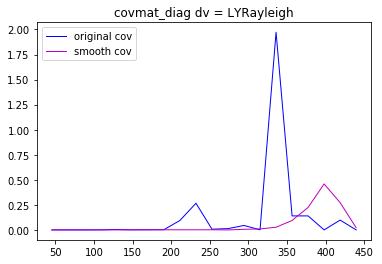

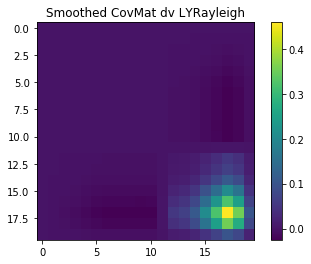

6
cv = 1871  and dv = 1948
cv POT = 579534847420999991296.000000 dv POT = 589862945463999987712.000000
cv[0] =  104.511012    cv[1] = 107.527385  rat = 0.492887
bwid = 89.562916


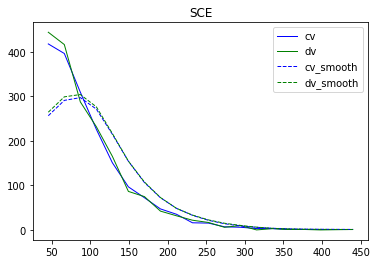

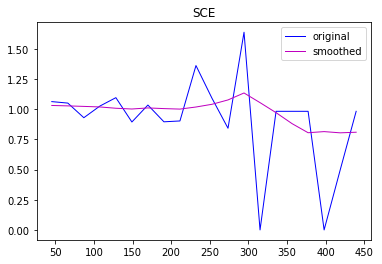

shower2_E_Y_new [9.57217620e-04 7.54136437e-04 5.40069556e-04 3.46990908e-04
 6.10975744e-05 2.70518669e-06 1.10617395e-04 2.44391859e-05
 7.36261423e-07 3.29845239e-04 1.65329724e-03 5.90062696e-03
 1.80482356e-02 2.94836255e-03 8.22830065e-04 1.43253802e-02
 3.79909391e-02 3.44607385e-02 3.83028876e-02 3.63931827e-02]
shower2_E_Y_new [3.95236727e-03 2.56593660e-03 4.97028882e-03 6.68135956e-04
 9.13364045e-03 1.12324708e-02 1.18278515e-03 1.09066136e-02
 9.48425484e-03 1.30753895e-01 8.23522329e-03 2.49213993e-02
 4.06386449e-01 1.00000000e+00 3.06576226e-04 3.06576226e-04
 3.06576226e-04 1.00000000e+00 2.54854503e-01 3.06576226e-04]


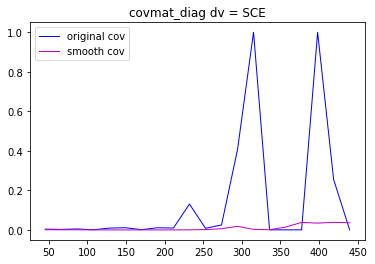

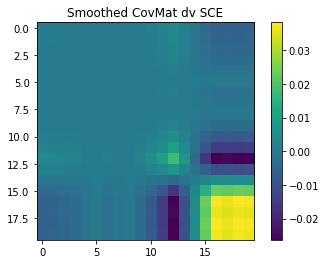

7
cv = 2807  and dv = 4092
cv POT = 898773223801000034304.000000 dv POT = 1264027045189999919104.000000
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


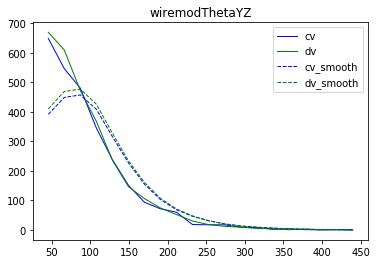

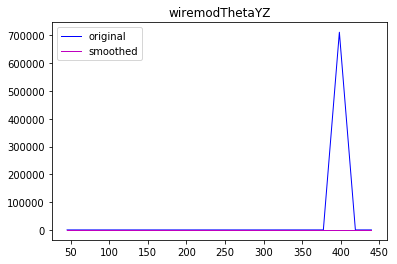

shower2_E_Y_new [2.24291928e-03 1.99962189e-03 1.85223975e-03 1.70949129e-03
 1.40093355e-03 9.39290356e-04 1.19415979e-03 1.68140331e-03
 1.77362674e-03 8.20462649e-04 8.62285613e-06 2.60567521e-04
 2.59294426e-03 1.03518051e-02 9.65654842e-03 1.77963118e-03
 4.62783213e-02 2.00387893e-01 1.29184920e-01 1.14050366e-02]
shower2_E_Y_new [1.03318734e-03 1.33583591e-02 2.72482994e-04 4.24792548e-03
 6.92688646e-05 8.95531512e-04 1.75233829e-02 1.57978315e-03
 1.71371987e-02 4.38548062e-01 2.21710062e-03 8.76746616e-02
 4.40027503e-04 1.42763362e-01 1.28395789e+00 5.82148881e-01
 3.40091949e+00 0.00000000e+00 8.34981406e-02 0.00000000e+00]


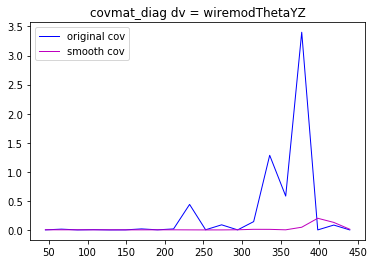

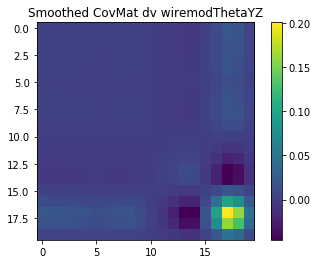

8
cv = 2807  and dv = 3911
cv POT = 898773223801000034304.000000 dv POT = 1296977725840000024576.000000
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


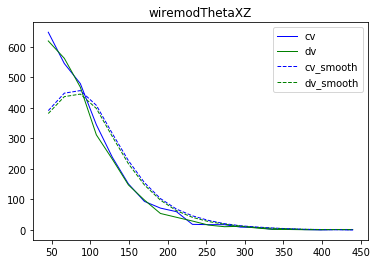

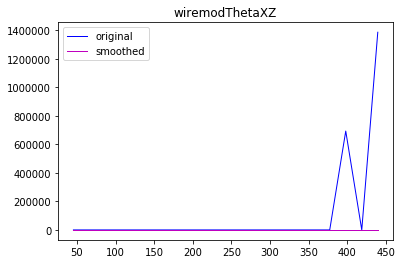

shower2_E_Y_new [0.00057976 0.00064472 0.00062961 0.00061599 0.00097697 0.00199498
 0.00242601 0.00248697 0.0057425  0.01133688 0.01498513 0.00797944
 0.00536276 0.01967033 0.02257224 0.00457344 0.00081606 0.05710059
 0.21612186 0.40104627]
shower2_E_Y_new [0.00195102 0.00098875 0.00059695 0.00925109 0.00071074 0.00054236
 0.00228303 0.06049939 0.09512964 0.35547182 0.0068377  0.15012287
 0.0883099  0.04857751 0.0015573  0.28946189 0.09426431 0.
 0.1489575  0.        ]


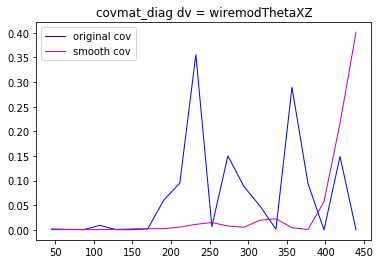

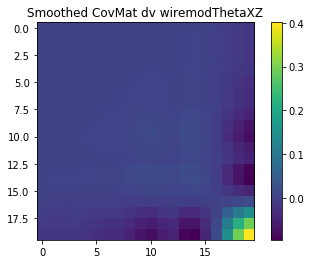

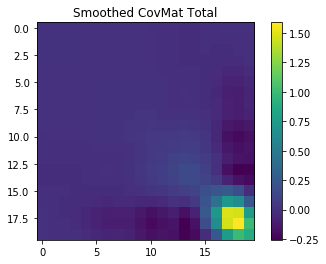

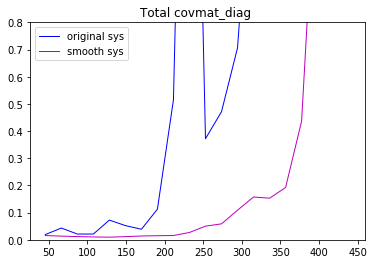

In [70]:
nbins = 20

if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)
if not os.path.exists(covfolder):
    os.makedirs(covfolder)

    
#for dist in varListSel: #[9:10]
#for _,dist in varListSel.items(): # loop over all variables 
for i in range(1):
    dist = varlistSel['shower2_E_Y_new']
#    dist = varListSel['MPID_muon']

    cov = np.zeros((nbins,nbins))
    cov_smooth = np.zeros((nbins,nbins))

    
    print(len(a_df_sys))
    for sysi in range(len(a_df_sys)): # loop over all detvars
#    for sysi in range(1):
#        sysi = 3
#        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        print(sysi)
        myvardf = a_df_sys[sysi]
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts_cv)[dist.myname]
        print('cv = %d  and dv = %d'%(var_cv.shape[0],var_sys.shape[0]))

        pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
        pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
        print("cv POT = %f dv POT = %f"%(pot_cv,pot_dv))

        
        # get cv and detvar lists and apply weights
        var_cv_list = np.array(var_cv.astype(float).values.tolist())
        var_sys_list = np.array(var_sys.astype(float).values.tolist())
        cv_weights = np.array(myvardf.query(s_cuts_cv)['xsec_corr_weight'].astype(float).values.tolist())
        dv_weights = np.array(myvardf.query(s_cuts)['xsec_corr_weight'].astype(float).values.tolist())
        ratio = pot_cv / pot_dv

#        var_cv_list = var_cv_list * cv_weights 

#        var_sys_list = var_sys_list * sys_weights 
        
        
        
        CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=cv_weights,dv_weights=dv_weights,nbin=nbins,ratio=ratio)
        #CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=1,dv_weights=1,nbin=nbins,ratio=ratio)


        
#        print(cv_weights)
        hCV,binedges = np.histogram(var_cv_list,bins=nbins,range=dist.myrange,weights= cv_weights)#cv_scale)
        h0,_ = np.histogram(var_sys_list,bins=nbins,range=dist.myrange,weights=dv_weights)#cv_scale)
        bincenters = np.diff(binedges)/2 + binedges[:-1] 
        h0 = h0 *ratio

        cov_tmp = np.zeros((nbins,nbins))
        cov_smooth_tmp = np.zeros((nbins,nbins))            
        for i in range(nbins):
            for j in range(nbins):
                if (hCV[i]*hCV[j])<1e-5:
                    cov_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
    #    print(dist.myname,cov.diagonal())
        for i in range(nbins):
            for j in range(nbins):
                if (CV_smooth[i]*CV_smooth[j])<1e-8:
                    cov_smooth_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_smooth_tmp[i][j] += (DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j])/(CV_smooth[i]*CV_smooth[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
        print(dist.myname,cov_smooth_tmp.diagonal())
        print(dist.myname,cov_tmp.diagonal())
        
        offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
        x= np.linspace(dist.myrange[0]+offset,dist.myrange[1]-offset,nbins)
        plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
        plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
        plt.legend()
        plt.title('covmat_diag dv = %s'%names[sysi])
        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        
        plt.show()
        
        plt.imshow(cov_smooth_tmp, interpolation='none')
        plt.colorbar(orientation='vertical')
        plt.title('Smoothed CovMat dv %s'%names[sysi])

        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        plt.show()

        cov = cov+ cov_tmp
        cov_smooth = cov_smooth + cov_smooth_tmp
    plt.imshow(cov_smooth, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.title('Smoothed CovMat Total')

    plt.savefig(plotfolder+'/detsys_%s_%s_cov.png'%(dist.myname, run),dpi=120,bbox_inches='tight')

    plt.show()
    np.savetxt(covfolder+'/detsys_%s_%s_cov.csv'%(dist.myname, run),cov_smooth, delimiter=',')
    
    
    
    plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original sys')
    plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth sys')
    plt.legend()
    plt.ylim([0,0.8])
    plt.title('Total covmat_diag ')
    plt.savefig(plotfolder+'/Tot_sys_%s_cov.png'%(run),dpi=120,bbox_inches='tight')
        

## Run 1


In [71]:
run = 'run1'
f_scaleslist = []
s_detsyslist = []
names = ['wiremodX','wiremodYZ','recomb','LYdown','LYRayleigh','SCE','wiremodThetaYZ','wiremodThetaXZ']

for name in names:
    s_detsyslist.append(name)

#df_cv = pd.read_parquet('../../data/pickles/detsys_CV_run3_nodupesMay1.parquet')
#scaleCV = 9.65858292241e+19 

a_df_sys = []

i=0
for sys in s_detsyslist:
#    print('111')
    df_sys = pd.read_parquet('%s/pickles/%s_%s_%s.parquet'%(datafolder,sys,run,tag))
    print(df_sys.shape[0])
    i+=1
    a_df_sys.append(df_sys)
    print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))

327918
total 327918, cv = 315002 dv = 12916
327860
total 327860, cv = 315002 dv = 12858
13079
total 13079, cv = 6200 dv = 6879
11936
total 11936, cv = 6200 dv = 5736
13066
total 13066, cv = 6200 dv = 6866
12631
total 12631, cv = 6200 dv = 6431
327883
total 327883, cv = 315002 dv = 12881
326568
total 326568, cv = 315002 dv = 11566


8
0
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


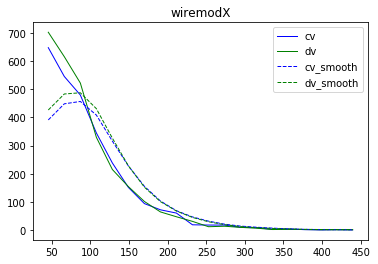

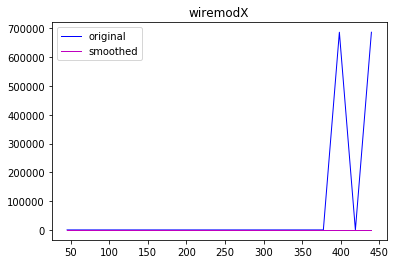

shower2_E_Y_new [7.51337160e-03 5.64555650e-03 4.26991055e-03 2.93187894e-03
 1.06262606e-03 7.21246766e-06 4.06566900e-04 4.39577037e-04
 2.79577593e-04 1.50825591e-03 5.40443255e-03 8.27792065e-03
 1.69014664e-02 4.35285141e-02 3.65943493e-02 1.17445193e-02
 3.89705880e-08 5.19530943e-02 1.34945434e-01 1.22981215e-01]
shower2_E_Y_new [7.14152850e-03 1.66374532e-02 7.86264550e-03 2.01595655e-03
 9.54122797e-03 3.63362038e-04 6.41792722e-03 1.10669281e-02
 4.77886468e-02 4.45194625e-01 1.14723594e-01 5.79260849e-02
 2.02093391e-04 5.18261193e-02 9.82633055e-02 9.82633055e-02
 1.39174086e-01 0.00000000e+00 9.82633055e-02 0.00000000e+00]


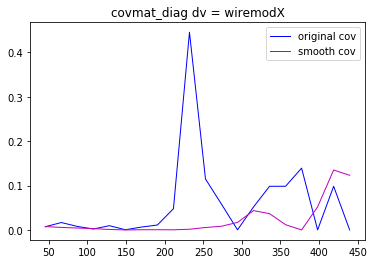

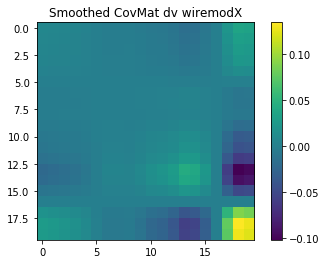

1
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


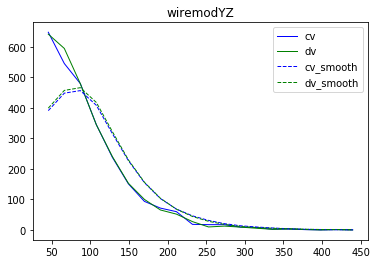

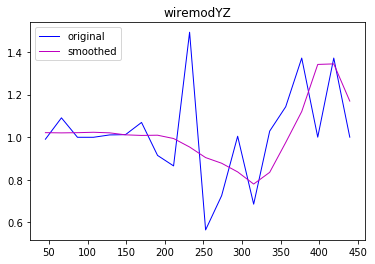

shower2_E_Y_new [4.36686975e-04 3.95110665e-04 4.33298468e-04 5.14033955e-04
 4.03336919e-04 1.16709446e-04 6.50750353e-05 8.32209392e-05
 4.09839559e-05 2.24273056e-03 1.01693014e-02 1.70766290e-02
 3.17775084e-02 6.21226057e-02 3.26454768e-02 6.44279983e-04
 1.29227141e-02 8.68512720e-02 8.79767180e-02 2.45108668e-02]
shower2_E_Y_new [9.18547122e-05 8.21032993e-03 3.48489035e-07 3.38633890e-07
 1.07963884e-04 1.39745616e-04 4.76764336e-03 7.34810543e-03
 1.81981388e-02 2.42415600e-01 1.89506599e-01 7.54242640e-02
 1.79903636e-05 9.88608978e-02 8.04726782e-04 2.03435409e-02
 1.37757476e-01 0.00000000e+00 1.37757476e-01 0.00000000e+00]


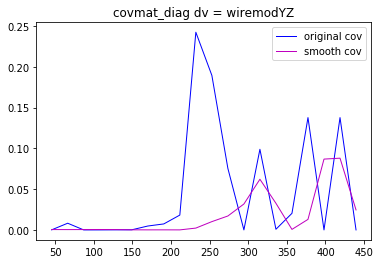

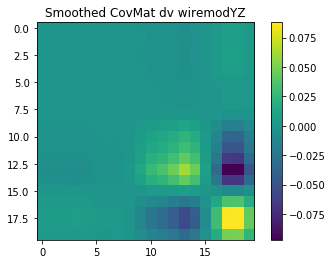

2
cv[0] =  76.417323    cv[1] = 50.749605  rat = 0.600921
bwid = 88.259030


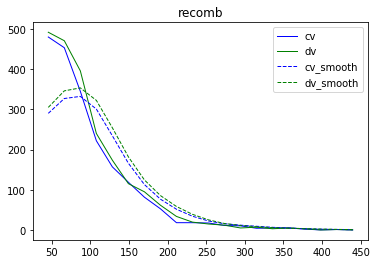

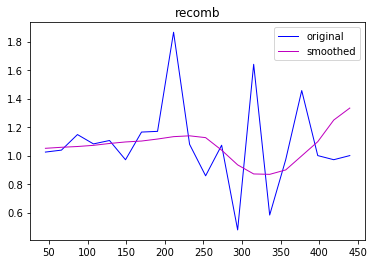

shower2_E_Y_new [2.48796499e-03 3.20989732e-03 3.82377388e-03 4.82749379e-03
 6.66813997e-03 8.37120291e-03 9.47515657e-03 1.21106185e-02
 1.56036236e-02 1.69258026e-02 1.41220543e-02 1.40005387e-03
 4.53630347e-03 1.90543256e-02 1.99620796e-02 1.12714290e-02
 2.65686641e-06 8.67788284e-03 4.98636381e-02 8.34630704e-02]
shower2_E_Y_new [6.09337307e-04 1.47524568e-03 2.17935133e-02 6.72943856e-03
 1.12171218e-02 8.52387828e-04 2.72809603e-02 2.89420486e-02
 7.49870548e-01 6.24446204e-03 2.01381605e-02 5.32144016e-03
 2.72251501e-01 4.10823640e-01 1.74162801e-01 8.34070702e-04
 2.08556236e-01 0.00000000e+00 8.34070702e-04 0.00000000e+00]


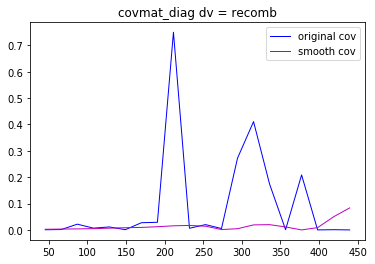

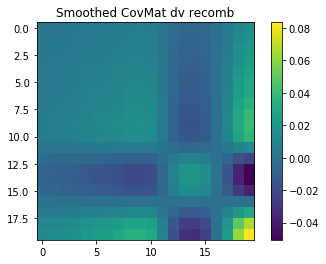

3
cv[0] =  76.417323    cv[1] = 50.749605  rat = 0.600921
bwid = 88.259030


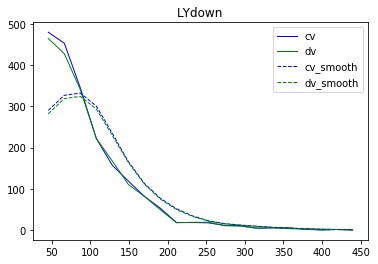

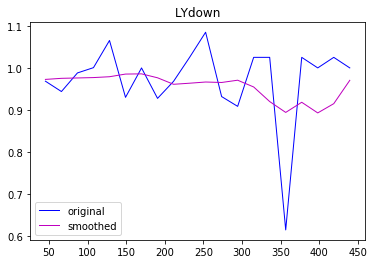

shower2_E_Y_new [0.00076789 0.00062928 0.00058489 0.00054063 0.00044856 0.00021769
 0.00020289 0.00056537 0.00157626 0.00137259 0.00116364 0.00124193
 0.00088013 0.00214802 0.00694542 0.01251148 0.00725955 0.0128068
 0.00788813 0.00089934]
shower2_E_Y_new [9.96187925e-04 3.15402824e-03 1.42389615e-04 3.62924146e-07
 4.25102676e-03 4.89575755e-03 7.29357127e-09 5.24131246e-03
 1.01544092e-03 6.29160701e-04 7.18049951e-03 4.63846736e-03
 8.34772941e-03 6.29160701e-04 6.29160701e-04 1.48186621e-01
 6.29160701e-04 0.00000000e+00 6.29160701e-04 0.00000000e+00]


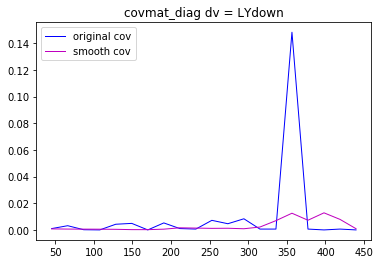

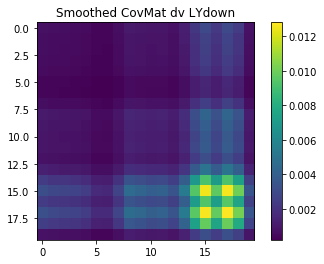

4
cv[0] =  76.417323    cv[1] = 50.749605  rat = 0.600921
bwid = 88.259030


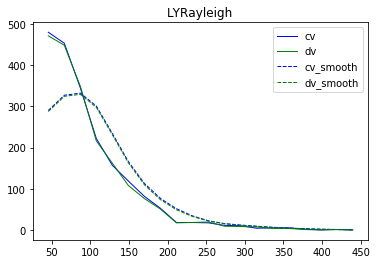

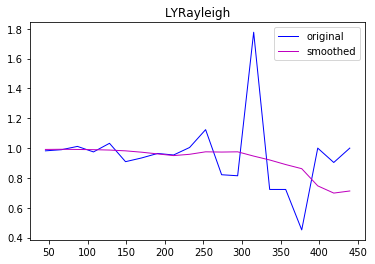

shower2_E_Y_new [8.08364744e-05 6.16089060e-05 8.21875613e-05 1.09522509e-04
 1.72354817e-04 3.40484155e-04 7.69385738e-04 1.56624113e-03
 2.64661419e-03 1.79385721e-03 6.32390695e-04 7.21038982e-04
 6.33949464e-04 3.02204940e-03 6.86230172e-03 1.36582399e-02
 2.20383158e-02 8.56442904e-02 1.29953872e-01 1.15788980e-01]
shower2_E_Y_new [3.32354785e-04 1.14910076e-04 1.30619756e-04 6.51463503e-04
 1.03615296e-03 8.25692949e-03 4.36406722e-03 1.28763553e-03
 2.12197918e-03 1.71575139e-05 1.53149496e-02 3.18369578e-02
 3.43284038e-02 6.02711356e-01 7.67387744e-02 7.67387744e-02
 3.00453104e-01 0.00000000e+00 9.26830826e-03 0.00000000e+00]


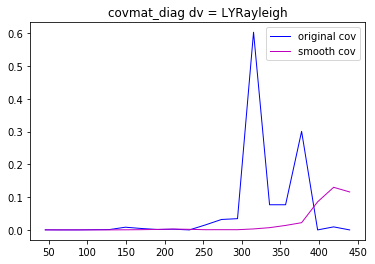

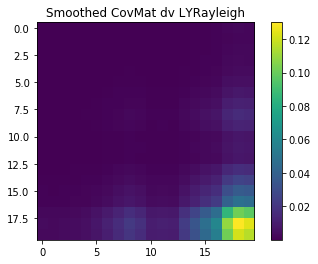

5
cv[0] =  76.417323    cv[1] = 50.749605  rat = 0.600921
bwid = 88.259030


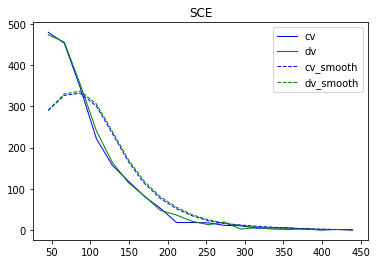

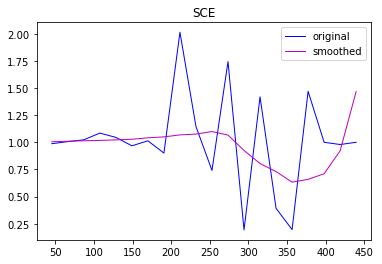

shower2_E_Y_new [2.02969200e-05 9.60162912e-05 1.95513441e-04 2.99968825e-04
 4.90236717e-04 7.71986743e-04 1.63956621e-03 2.37569455e-03
 4.36671485e-03 5.33066830e-03 8.95618486e-03 4.13524130e-03
 6.08589326e-03 4.76529458e-02 9.94654968e-02 2.12785606e-01
 1.76666617e-01 1.17947218e-01 6.59855579e-03 1.49045737e-01]
shower2_E_Y_new [1.60603483e-04 3.82347930e-05 5.28999155e-04 7.22783946e-03
 2.04659120e-03 1.03883525e-03 1.84939556e-04 9.80841452e-03
 1.02781614e+00 2.11412100e-02 6.69917732e-02 5.52935596e-01
 6.51284867e-01 1.75518929e-01 3.69813508e-01 6.46514846e-01
 2.20466854e-01 0.00000000e+00 4.12388309e-04 0.00000000e+00]


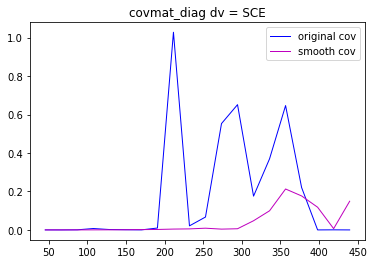

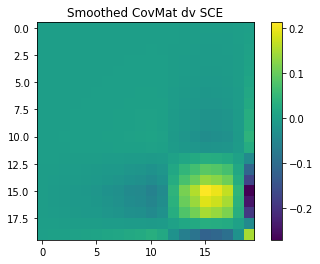

6
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


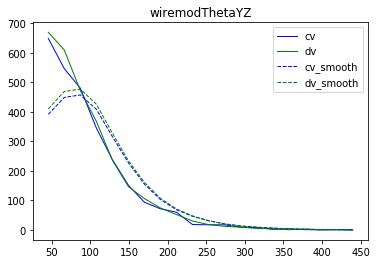

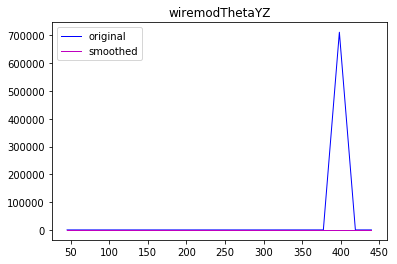

shower2_E_Y_new [2.14149903e-03 1.91403188e-03 1.77581293e-03 1.64161700e-03
 1.35038975e-03 9.11359163e-04 1.15427206e-03 1.61517326e-03
 1.70195006e-03 7.97615961e-04 8.59760951e-06 2.64842639e-04
 2.73206356e-03 1.15243349e-02 1.07088865e-02 1.70759513e-03
 3.80852674e-02 1.38423168e-01 9.50292268e-02 1.03045669e-02]
shower2_E_Y_new [1.03318734e-03 1.33583591e-02 2.72482994e-04 4.24792548e-03
 6.92688646e-05 8.95531512e-04 1.75233829e-02 1.57978315e-03
 1.71371987e-02 4.38548062e-01 2.21710062e-03 8.76746616e-02
 4.40027503e-04 1.42763362e-01 1.28395789e+00 5.82148881e-01
 3.40091949e+00 0.00000000e+00 8.34981406e-02 0.00000000e+00]


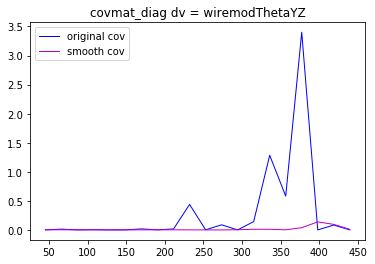

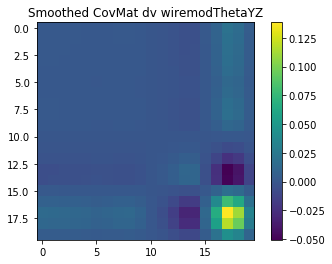

7
cv[0] =  62.949348    cv[1] = 58.428616  rat = 0.518623
bwid = 84.520842


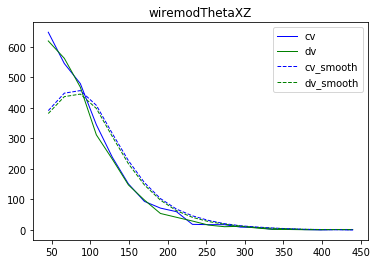

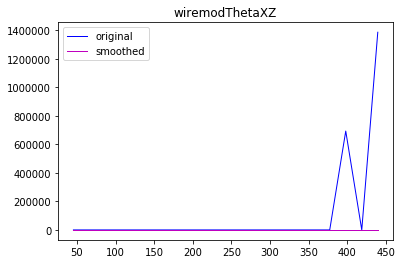

shower2_E_Y_new [0.00059407 0.00066152 0.00064581 0.00063167 0.0010085  0.00208825
 0.00255169 0.0026175  0.00621334 0.01268781 0.01707539 0.00876214
 0.00578651 0.02287916 0.0265631  0.00490516 0.0007934  0.04608761
 0.14753463 0.24554623]
shower2_E_Y_new [0.00195102 0.00098875 0.00059695 0.00925109 0.00071074 0.00054236
 0.00228303 0.06049939 0.09512964 0.35547182 0.0068377  0.15012287
 0.0883099  0.04857751 0.0015573  0.28946189 0.09426431 0.
 0.1489575  0.        ]


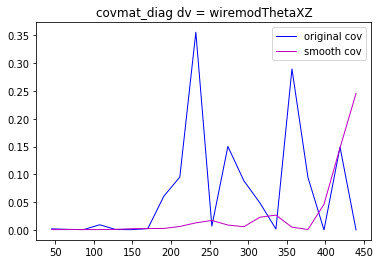

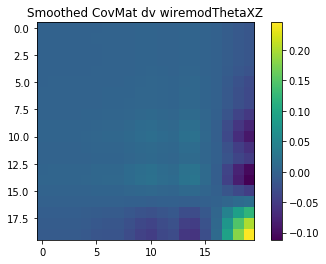

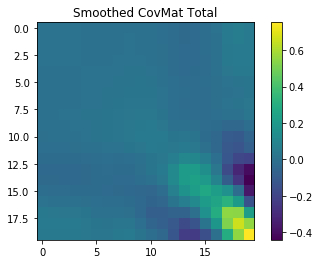

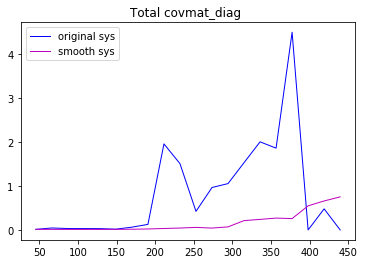

In [72]:

nbins = 20
if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)
if not os.path.exists(covfolder):
    os.makedirs(covfolder)

    
#for dist in varListSel: #[9:10]
#for _,dist in varListSel.items(): # loop over all variables 
for i in range(1):
    dist = varlistSel['shower2_E_Y_new']
#    dist = varListSel['MPID_muon']

    cov = np.zeros((nbins,nbins))
    cov_smooth = np.zeros((nbins,nbins))

    
    print(len(a_df_sys))
    for sysi in range(len(a_df_sys)): # loop over all detvars
#    for sysi in range(1):
#        sysi = 3
#        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        print(sysi)
        myvardf = a_df_sys[sysi]
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts_cv)[dist.myname]
        # get cv and detvar lists and apply weights
        var_cv_list = np.array(var_cv.astype(float).values.tolist())
        var_sys_list = np.array(var_sys.astype(float).values.tolist())
        cv_weights = np.array(myvardf.query(s_cuts_cv)['xsec_corr_weight'].astype(float).values.tolist())
        dv_weights = np.array(myvardf.query(s_cuts)['xsec_corr_weight'].astype(float).values.tolist())

        
        pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
        pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
        ratio =pot_cv/pot_dv
        #        var_cv_list = var_cv_list * cv_weights

#        var_sys_list = var_sys_list * sys_weights
        
        
        CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=cv_weights,dv_weights=dv_weights,nbin=nbins,ratio=ratio)


        
#        print(cv_weights)
        hCV,binedges = np.histogram(var_cv_list,bins=nbins,range=dist.myrange,weights= cv_weights)#cv_scale)
        h0,_ = np.histogram(var_sys_list,bins=nbins,range=dist.myrange,weights=dv_weights)#cv_scale)
        bincenters = np.diff(binedges)/2 + binedges[:-1] 
        h0 = h0 *ratio
        


        cov_tmp = np.zeros((nbins,nbins))
        cov_smooth_tmp = np.zeros((nbins,nbins))            
        for i in range(nbins):
            for j in range(nbins):
                if (hCV[i]*hCV[j])<1e-8:
                    cov_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
    #    print(dist.myname,cov.diagonal())
        
        for i in range(nbins):
            for j in range(nbins):
                if (CV_smooth[i]*CV_smooth[j])<1e-8:
                    cov_smooth_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_smooth_tmp[i][j] += (DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j])/(DV_smooth[i]*CV_smooth[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
        print(dist.myname,cov_smooth_tmp.diagonal())
        print(dist.myname,cov_tmp.diagonal())
        
        offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
        x= np.linspace(dist.myrange[0]+offset,dist.myrange[1]-offset,nbins)
        plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
        plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
        plt.legend()
        plt.title('covmat_diag dv = %s'%names[sysi])
        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        
        plt.show()
        
        plt.imshow(cov_smooth_tmp, interpolation='none')
        plt.colorbar(orientation='vertical')
        plt.title('Smoothed CovMat dv %s'%names[sysi])

        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        plt.show()

        cov = cov+ cov_tmp
        cov_smooth = cov_smooth + cov_smooth_tmp
    plt.imshow(cov_smooth, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.title('Smoothed CovMat Total')

    plt.savefig(plotfolder+'/detsys_%s_%s_cov.png'%(dist.myname, run),dpi=120,bbox_inches='tight')

    plt.show()
    np.savetxt(covfolder+'/detsys_%s_%s_cov.csv'%(dist.myname, run),cov_smooth, delimiter=',')
    
    plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original sys')
    plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth sys')
    plt.legend()
    #plt.ylim()
    plt.title('Total covmat_diag ')
    plt.savefig(plotfolder+'/Tot_sys_%s_cov.png'%(run),dpi=120,bbox_inches='tight')